In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import tqdm


plt.style.use(['science', 'grid', 'notebook'])

# Estadística de trenes de spikes

## Carga de datos

Cargo el estímulo

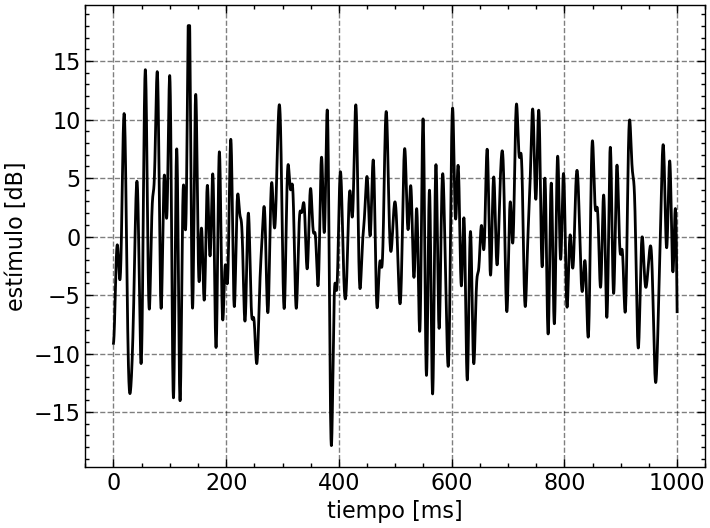

In [2]:
stimulus_path = './data/stimulus.dat'
stimulus = pd.read_csv(stimulus_path, sep='\t', names=['time', 'signal'])

plt.figure(figsize=(8,6))
plt.plot(stimulus['time'], stimulus['signal'], color='k')
plt.xlabel('tiempo [ms]')
plt.ylabel('estímulo [dB]')
plt.savefig('./doc/figures/stimulus.pdf', bbox_inches='tight')

In [3]:
spike_path = './data/spikes.dat'

# Leo los spikes con funciones nativas por como estan guardados
spikes = []
with open(spike_path, 'r') as f:
    for line in f:
        spikes.append([float(x) for x in line.strip().split()])

spikes = np.array(spikes)
# print(spikes.shape)

Spikes

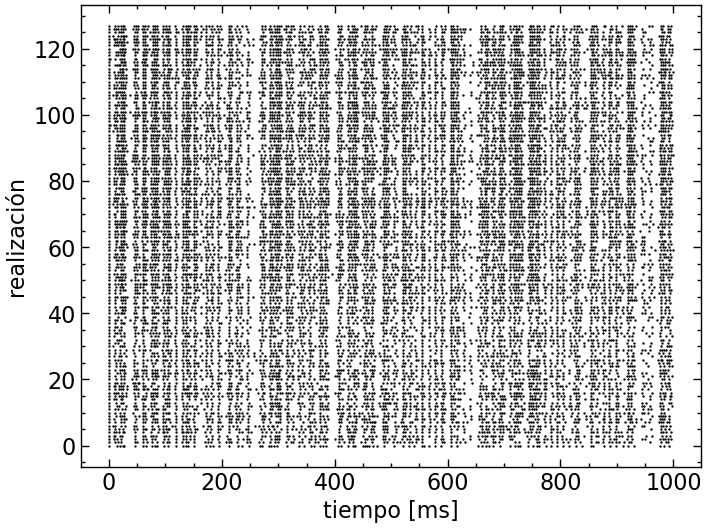

In [4]:
delta_time = 0.1

plt.figure(figsize=(8,6))
for i in range(spikes.shape[0]):
    index = np.where(spikes[i] == 1)[0]
    plt.scatter(index*delta_time, np.ones_like(index) * i, s=0.5, c='k')

plt.grid()
plt.xlabel('tiempo [ms]')
plt.ylabel('realización')
plt.savefig('./doc/figures/spikes.pdf', bbox_inches='tight')

Pongo los 2 en una misma grafica que compartan ejes

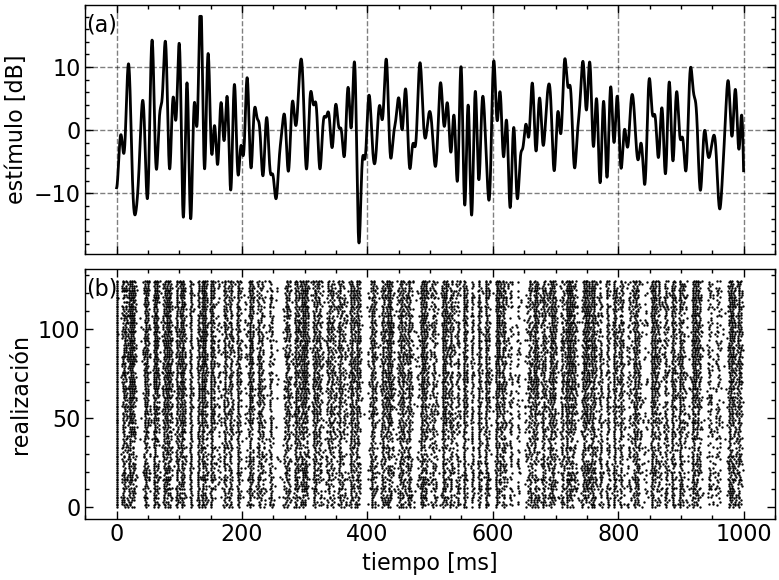

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)

ax[0].plot(stimulus['time'], stimulus['signal'], color='k')
ax[0].set_ylabel('estímulo [dB]')
ax[0].text(0.024, 0.92, '(a)', fontsize=16, transform=ax[0].transAxes, ha='center', va='center')

for i in range(spikes.shape[0]):
    index = np.where(spikes[i] == 1)[0]
    ax[1].scatter(index*delta_time, np.ones_like(index) * i, s=0.5, c='k')

ax[1].set_xlabel('tiempo [ms]')
ax[1].set_ylabel('realización')
ax[1].text(0.024, 0.92, '(b)', fontsize=16, transform=ax[1].transAxes, ha='center', va='center')
ax[1].grid()

plt.tight_layout()
plt.savefig('./doc/figures/estimu_spikes.pdf', bbox_inches='tight')



## Inciso 1

Coeficiente de variabilidad

$$CV = \frac{\sigma_\text{ISI}}{\langle ISI \rangle}$$

CV: 0.6572287857646664


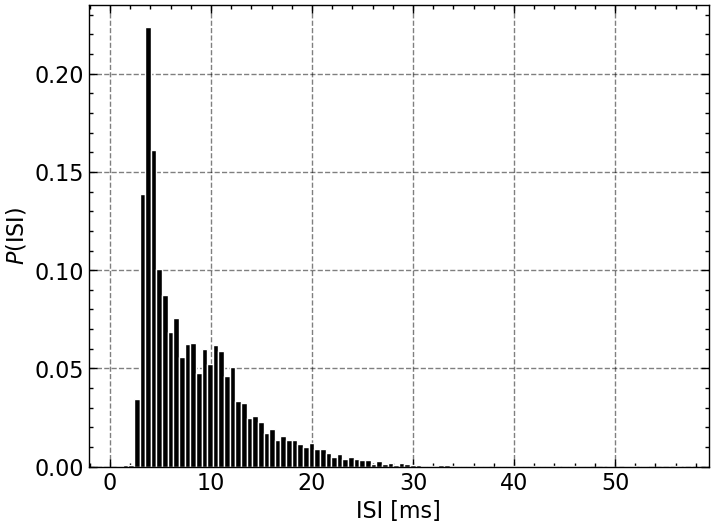

In [6]:
ISI = []    # Inter Spike Interval
delta_time = 0.1


for i in range(spikes.shape[0]):
    index = np.where(spikes[i] == 1)[0]
    if len(index) > 1:
        ISI.append([index[j+1] - index[j] for j in range(len(index)-1)])

# concateno todos los ISI
ISI = np.concatenate(ISI)

plt.hist(ISI*delta_time, bins=100, density=True, color='black', edgecolor='white')
plt.xlabel('ISI [ms]')
plt.ylabel(r'$P(\text{ISI})$')
plt.savefig('./doc/figures/ISI.pdf', bbox_inches='tight')

print(f'CV: {np.std(ISI) / np.mean(ISI)}')

## Inciso 2

Obtener P(N) en una dada realización

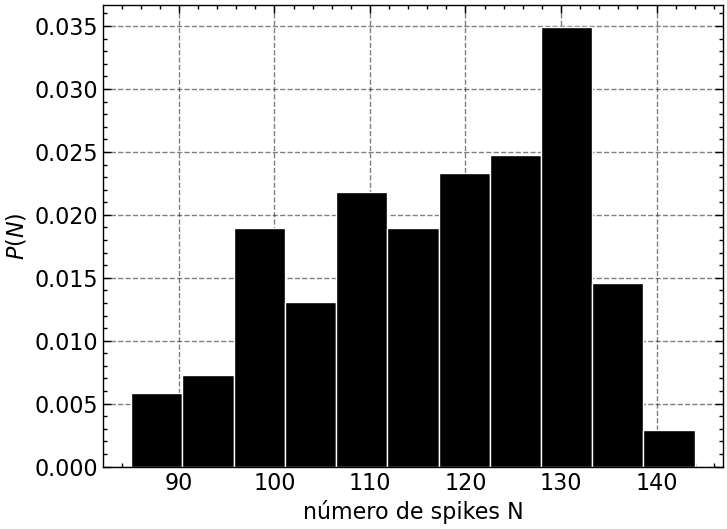

In [7]:
spikes_count = np.sum(spikes, axis=1)

plt.hist(spikes_count, bins=11, density=True, color='black', edgecolor='white')
plt.xlabel('número de spikes N')
plt.ylabel(r'$P(N)$')
plt.savefig('./doc/figures/spikes_count.pdf', bbox_inches='tight')

Factor de Fano: $$F = \frac{\sigma^2}{\langle N \rangle}$$

In [8]:
print(f'Fano Factor: {np.var(spikes_count) / np.mean(spikes_count)}')
print(f'CV2: {np.var(ISI) / np.mean(ISI)**2}')

is_renewal = True if np.isclose(np.var(ISI)/np.mean(ISI)**2, np.var(spikes_count) / np.mean(spikes_count), atol=0.1) else False
print(f'Is it a renewal process?: {is_renewal}')

Fano Factor: 1.5656668349803031
CV2: 0.43194967683769775
Is it a renewal process?: False


## Inciso 3

Estimar la tasa de disparo dependiente del tiempo r(t), promediando todas la realizaciones y usando un tamanño de bin adecuado.

Time interval: 10.0 ms
Number of iterations: 100


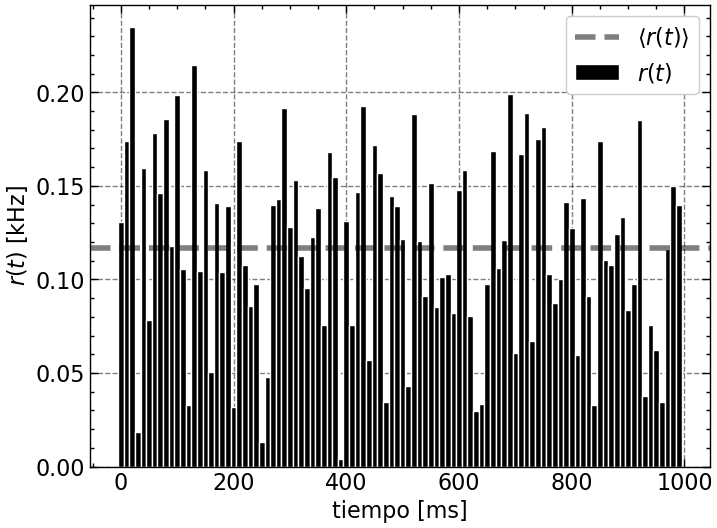

In [9]:
window = 100    # numero de bins
n_iter = int(spikes.shape[1] / window)  # numero de iteraciones

rate = []

print(f'Time interval: {delta_time*window} ms')
print(f'Number of iterations: {n_iter}')


for i in range(n_iter):
    r = spikes[:, i*window:(i+1)*window].sum(axis=1).mean() / (delta_time * window)
    rate.append(r)

rate = np.array(rate)
time_axis = np.arange(0, n_iter*window*delta_time, window*delta_time)
plt.bar(time_axis, rate, label=r'$r(t)$', color='black', width=window*delta_time, edgecolor='white')
plt.axhline(rate.mean(), color='black', linestyle='--', label=r'$\langle r(t) \rangle$', lw=4, alpha=0.5)
plt.xlabel('tiempo [ms]')
plt.ylabel(r'$r(t)$ [kHz]')
plt.legend()
plt.savefig('./doc/figures/rate.pdf', bbox_inches='tight')


## Ejercicio 4

Calcular el filtro asociado a esta neurona, que da la mejor predicción lineal del histograma dependiente del tiempo r(t). Despreciar el tiempo de autocorrelación del estímulo.

In [49]:
tau_limits = [0, 1000]
n_taus = 5000

tau_axis = np.linspace(*tau_limits, n_taus)

# Busco los indices un tau antes de los spikes

C = np.zeros_like(tau_axis)

# Busco los spikes
index_spikes = []
for i in range(spikes.shape[0]):
    index = np.where(spikes[i] == 1)[0]
    index_spikes.append(index)


for i, tau in tqdm.tqdm(enumerate(tau_axis), total=n_taus):
    for j in range(spikes.shape[0]):
        index = index_spikes[j]
        index = index[index > int(tau/delta_time)]

        if len(index) > 0:
            C[i] += stimulus['signal'].iloc[index - int(tau/delta_time)].sum()
            if stimulus['signal'].iloc[index - int(tau/delta_time)].sum() == np.nan:
                print('Nan')
        else:
            print('No hay spikes')

    if C[i] == np.nan:
        raise ValueError('Nan')
    
N_trials = spikes.shape[0]
C /= N_trials

print(np.any(np.isnan(C)))

 99%|█████████▊| 4927/5000 [00:46<00:00, 83.73it/s] 

No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes


 99%|█████████▉| 4959/5000 [00:46<00:00, 95.18it/s]

No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay

100%|██████████| 5000/5000 [00:46<00:00, 106.82it/s]

No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay spikes
No hay

[]
Tau max: 6.00120024004801


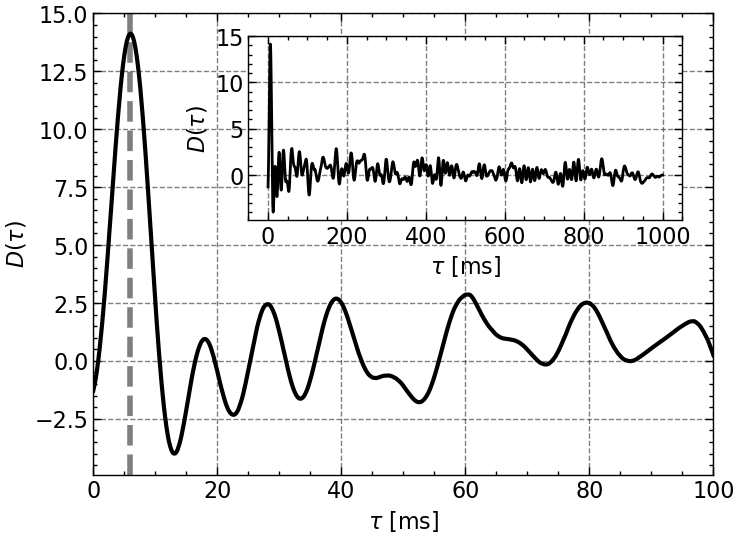

In [51]:
index_nan = np.where(np.isnan(C))[0]
print(index_nan)

fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(tau_axis, C/stimulus['signal'].var(), color='black', lw=3)
ax.set_xlim(0, 100)
ax.set_xlabel(r'$\tau$ [ms]')
ax.set_ylabel(r'$D(\tau)$')

index_max = np.argmax(C)
print(f'Tau max: {tau_axis[index_max]}')

ax.axvline(tau_axis[index_max], color='black', linestyle='--', lw=4, alpha=0.5)

inserted_axis = ax.inset_axes([0.25, 0.55, 0.7, 0.4])

inserted_axis.plot(tau_axis, C/stimulus['signal'].var(), color='black')
inserted_axis.set_xlabel(r'$\tau$ [ms]')
inserted_axis.set_ylabel(r'$D(\tau)$')

fig.savefig('./doc/figures/correlogram.pdf', bbox_inches='tight')